In [1]:
import torch 
import numpy as np
import math
import pandas as pd 
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

In [2]:
DATASET_DIR = "C:/Users/db/Desktop/기업-수강ncf/NCF 졸업생 데이터"
train= pd.read_csv(DATASET_DIR+ "/NCF 졸업생 데이터 (1부).csv", sep='|')[['sex','ccd','bzc_cd','grup_cd']]
test = pd.read_csv(DATASET_DIR+ "/NCF 졸업생 데이터 (2부).csv", sep='|')[['sex','ccd','bzc_cd','grup_cd']]

C:\Users\db\AppData\Local\Temp\ipykernel_26104\1374857115.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  train= pd.read_csv(DATASET_DIR+ "/NCF 졸업생 데이터 (1부).csv", sep='|')[['sex','ccd','bzc_cd','grup_cd']]
C:\Users\db\AppData\Local\Temp\ipykernel_26104\1374857115.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv(DATASET_DIR+ "/NCF 졸업생 데이터 (2부).csv", sep='|')[['sex','ccd','bzc_cd','grup_cd']]


In [3]:
rating_list = np.concatenate([train.values, test.values])
n_rating_list = []
for a in rating_list:
    sex,ccd,bzc_cd,grup_cd = a
    n_rating_list.append([sex,ccd,bzc_cd,grup_cd])
rating_list = np.array(n_rating_list)

In [4]:
# 모든 유저와 모든 item을 담음
unq_ccd, unq_bzccd,unq_grup_cd = [np.unique(rating_list[:, n+1]) for n in range(3)]
# user와 item의 개수 넣음
num_ccd, num_bzc, num_grup = len(unq_ccd), len(unq_bzccd),len(unq_grup_cd)
print('num_ccd:{} num_bzc:{} num_item:{}'.format(num_ccd, num_bzc, num_grup))
train_list = np.array(train)
test_list = np.array(test)
ccd2idx, bzcidx ,grupidx = {}, {},{}
for i, j in enumerate(unq_ccd):
     ccd2idx[j] = i
for i, j in enumerate(unq_bzccd):
     bzcidx[j] = i
for i, j in enumerate(unq_grup_cd):
     grupidx[j] = i    
from sklearn.model_selection import train_test_split
train_list = [[int(li[0])-1,ccd2idx[str(li[1])], bzcidx[str(li[2])],grupidx[str(li[3])]] for li in rating_list]
# x_train, x_test = train_test_split(train_list, test_size=0.3, shuffle=True, random_state=34)
train_list = pd.DataFrame(train_list, columns = ['sex', 'ccd','bzc','item'])
x_train, x_test = train_test_split(train_list, test_size=0.3, shuffle=True, stratify =train_list[['sex', 'ccd','bzc']], random_state=34)

num_ccd:314 num_bzc:925 num_item:16695


In [5]:
class DfData(torch.utils.data.Dataset):
    def __init__(self,features,num_sex,num_ccd,num_bzc,num_grup,num_ng=0,train_mat=None,is_training=None):
        super(DfData,self).__init__()
        # self.features_ps = torch.Tensor(features).int()
        self.features_ps = features
        self.num_sex = num_sex
        self.num_bzc = num_bzc
        self.num_ccd = num_ccd
        self.num_grup = num_grup
        self.num_ng = num_ng
        self.labels = [0] * len(features)
        self.train_mat = train_mat
        self.is_training = is_training
        
        # negative sampling 
    def set_ng_sample(self):
        assert self.is_training, "no need to sampling when testing"
         
        self.features_ng = []
        for x in self.features_ps:
            # sex
            for _ in range(self.num_ng):
                s = np.random.randint(self.num_sex)
                u = np.random.randint(self.num_ccd)
                q = np.random.randint(self.num_bzc)
                j = np.random.randint(self.num_grup)
                # train set에 있는 경우 다시 뽑기
                self.features_ng.append([s,u,q,j])

        labels_ps = [1] * len(self.features_ps)
        labels_ng = [0] * len(self.features_ng)
        
        self.features_fill = torch.Tensor(self.features_ps + self.features_ng).to(torch.int64)
        self.labels_fill= torch.Tensor(labels_ps + labels_ng)
        

    def __len__(self):
        return (self.num_ng+1) * len(self.labels)
        
    def __getitem__(self,idx):
        features = self.features_fill if self.is_training else torch.Tensor(self.features_ps).to(torch.int64)
        labels = self.labels_fill if self.is_training else torch.Tensor(self.labels)
        
        user = features[idx]
        label = labels[idx]
        return user, label

In [6]:
# x_train = x_train.values.tolist()
# x_test = x_test.values.tolist()
num_sex = 2
train_dataset = DfData(x_train, num_sex,num_ccd,num_bzc, num_grup, num_ng=1, is_training=True)
train_loader = data.DataLoader(train_dataset, batch_size = 128, shuffle=True, num_workers=0)
test_dataset = DfData(x_test, num_sex,num_ccd,num_bzc, num_grup, num_ng=1, is_training=True)
test_loader = data.DataLoader(test_dataset, batch_size = 128, shuffle=True, num_workers=0)

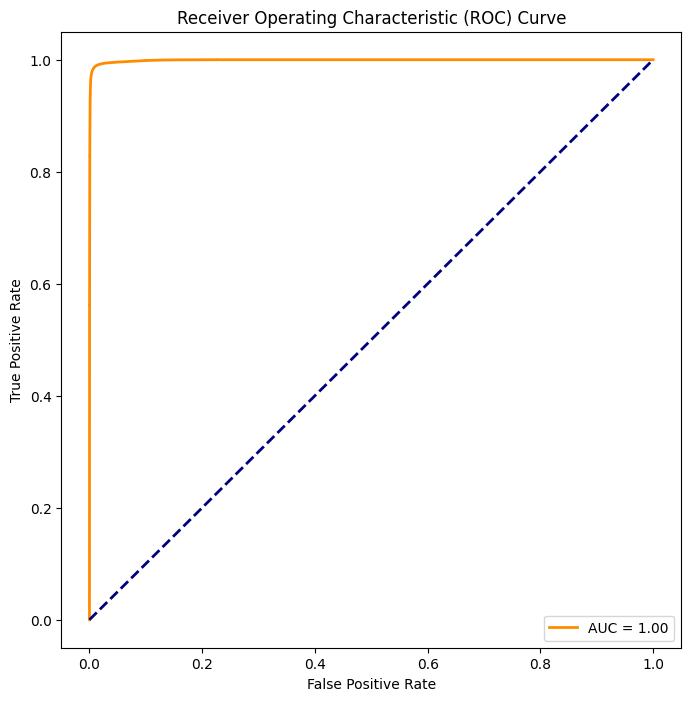

In [25]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize empty lists to store predictions and labels
all_predictions = []
all_labels = []

# Disable gradient computation
with torch.no_grad():
    test_loader.dataset.set_ng_sample()

    for user, label in test_loader:
        user = user.cuda()
        label = label.float().cuda()
        pred = net(user)

        # Move tensors to CPU before converting to NumPy arrays
        pred_np = pred.cpu().numpy()
        label_np = label.cpu().numpy()

        # Append predictions and labels for the current batch to the lists
        all_predictions.extend(pred_np)
        all_labels.extend(label_np)

# Convert lists to NumPy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Compute ROC curve and AUC for the entire dataset
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [26]:
roc_auc

0.9990558698192618

In [7]:
train_dataset.set_ng_sample()
for a,b in train_loader:
    print(a)
    print(b)
    break

tensor([[    1,   184,   755,  6154],
        [    0,    73,   916,   788],
        [    1,   157,   267,  6869],
        [    1,   310,   222, 16081],
        [    1,   148,   842,  3395],
        [    1,   100,   640, 13849],
        [    1,   122,   799,  2584],
        [    1,   293,   913,  9062],
        [    1,   150,   842,   240],
        [    0,    19,   799,  6898],
        [    0,    79,   226, 12739],
        [    0,   109,   429, 14151],
        [    1,   189,   323,   520],
        [    0,   171,   615,  4020],
        [    0,   103,   337,  4437],
        [    0,   215,   558,  7946],
        [    1,   120,   536,  6909],
        [    1,    91,   684,    41],
        [    0,   181,   762, 12929],
        [    0,    41,   759,  4593],
        [    0,   284,   232,   217],
        [    0,   304,   757,  7236],
        [    1,    48,   600, 11897],
        [    0,    28,   671,  1380],
        [    1,   228,    19, 13236],
        [    0,   292,   212, 16520],
        [   

In [7]:
class FeaturesEmbedding(torch.nn.Module):

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int64())
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)

In [8]:
class FeaturesLinear(torch.nn.Module):

    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int64())
    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias

In [9]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, embed_dims, dropout, output_layer=True):
        super().__init__()
        layers = list()
        for embed_dim in embed_dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            layers.append(torch.nn.BatchNorm1d(embed_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout))
            input_dim = embed_dim
        if output_layer:
            layers.append(torch.nn.Linear(input_dim, 1))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, embed_dim)``
        """
        return self.mlp(x)

In [10]:
class LNN(torch.nn.Module):
    """
    A pytorch implementation of LNN layer
    Input shape
        - A 3D tensor with shape: ``(batch_size,field_size,embedding_size)``.
    Output shape
        - 2D tensor with shape:``(batch_size,LNN_dim*embedding_size)``.
    Arguments
        - **in_features** : Embedding of feature.
        - **num_fields**: int.The field size of feature.
        - **LNN_dim**: int.The number of Logarithmic neuron.
        - **bias**: bool.Whether or not use bias in LNN.
    """
    def __init__(self, num_fields, embed_dim, LNN_dim, bias=False):
        super(LNN, self).__init__()
        self.num_fields = num_fields
        self.embed_dim = embed_dim
        self.LNN_dim = LNN_dim
        self.lnn_output_dim = LNN_dim * embed_dim
        self.weight = torch.nn.Parameter(torch.Tensor(LNN_dim, num_fields))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(LNN_dim, embed_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields, embedding_size)``
        """
        embed_x_abs = torch.abs(x) # Computes the element-wise absolute value of the given input tensor.
        embed_x_afn = torch.add(embed_x_abs, 1e-7)
        # Logarithmic Transformation
        embed_x_log = torch.log1p(embed_x_afn) # torch.log1p and torch.expm1
        lnn_out = torch.matmul(self.weight, embed_x_log)
        if self.bias is not None:
            lnn_out += self.bias
        lnn_exp = torch.expm1(lnn_out)
        output = F.relu(lnn_exp).contiguous().view(-1, self.lnn_output_dim)
        return output


In [11]:
class AdaptiveFactorizationNetwork(torch.nn.Module):
    """
    A pytorch implementation of AFN.

    Reference:
        Cheng W, et al. Adaptive Factorization Network: Learning Adaptive-Order Feature Interactions, 2019.
    """
    def __init__(self, field_dims, embed_dim, LNN_dim, mlp_dims, dropouts):
        super().__init__()
        self.num_fields = len(field_dims)
        self.linear = FeaturesLinear(field_dims)    # Linear
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)   # Embedding
        self.LNN_dim = LNN_dim
        self.LNN_output_dim = self.LNN_dim * embed_dim
        self.LNN = LNN(self.num_fields, embed_dim, LNN_dim)
        self.mlp = MultiLayerPerceptron(self.LNN_output_dim, mlp_dims, dropouts[0])

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        embed_x = self.embedding(x)
        lnn_out = self.LNN(embed_x)
        x = self.linear(x) + self.mlp(lnn_out)
        return (x.squeeze(1))

In [12]:
sex = 2 
field_dims = [sex, num_ccd,num_bzc,num_grup]
embed_dim= 50
LNN_dim = 1000
mlp_dims = [50, 50] 
dropouts= (0, 0, 0)
device = 'cuda:0'

In [13]:
field_dims

[2, 314, 925, 16695]

In [14]:
net = AdaptiveFactorizationNetwork(field_dims, embed_dim , LNN_dim, mlp_dims, dropouts)

In [15]:
net.to(device)

AdaptiveFactorizationNetwork(
  (linear): FeaturesLinear(
    (fc): Embedding(17936, 1)
  )
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(17936, 50)
  )
  (LNN): LNN()
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=50000, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0, inplace=False)
      (8): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)

In [16]:
learning_rate = 0.005
epochs = 50
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [18]:
for ep in range(epochs):   
    avg_cost = 0
    train_loader.dataset.set_ng_sample()
    for user, label in train_loader:
        user = user.to(torch.int64).to(device)
        label = label.to('cuda:0')
        net.zero_grad()
        pred = net(user)
        loss = loss_function(pred, label)
        loss.backward()
        optimizer.step()
        avg_cost += loss / len(train_loader)
    net.eval()
    # HR = metrics(net, test_loader, 10)    
    # print(np.mean(HR))
    print('Epoch:', '%04d' % (ep + 1), 'cost =', '{:.9f}'.format(avg_cost)) 

Epoch: 0001 cost = 0.134577617
Epoch: 0002 cost = 0.044902582
Epoch: 0003 cost = 0.029850483
Epoch: 0004 cost = 0.022861408
Epoch: 0005 cost = 0.018879555
Epoch: 0006 cost = 0.016405053
Epoch: 0007 cost = 0.014906020
Epoch: 0008 cost = 0.013746433
Epoch: 0009 cost = 0.012833700
Epoch: 0010 cost = 0.012204620
Epoch: 0011 cost = 0.011775786
Epoch: 0012 cost = 0.011523630
Epoch: 0013 cost = 0.011058916
Epoch: 0014 cost = 0.011200616
Epoch: 0015 cost = 0.010706419
Epoch: 0016 cost = 0.010570126
Epoch: 0017 cost = 0.010395010
Epoch: 0018 cost = 0.010248264
Epoch: 0019 cost = 0.010208805
Epoch: 0020 cost = 0.010285851
Epoch: 0021 cost = 0.010150331
Epoch: 0022 cost = 0.009729362
Epoch: 0023 cost = 0.010112249
Epoch: 0024 cost = 0.009723805
Epoch: 0025 cost = 0.009883045
Epoch: 0026 cost = 0.009656291
Epoch: 0027 cost = 0.009790991
Epoch: 0028 cost = 0.009520132
Epoch: 0029 cost = 0.009890240
Epoch: 0030 cost = 0.009744785
Epoch: 0031 cost = 0.009505411
Epoch: 0032 cost = 0.009535932
Epoch: 0

In [ ]:
# "C:/Users/db/Desktop/AFN"

In [19]:
# torch.save(net ,"C:/Users/db/Desktop/AFN/AFN.pth")

In [17]:
net = torch.load("C:/Users/db/Desktop/AFN/AFN.pth")

In [18]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [19]:
x_train

array([[    0,   290,   649,  1946],
       [    1,   143,   799, 11417],
       [    0,    18,   410,  8453],
       ...,
       [    1,   196,   593,   504],
       [    1,   201,   505,  3704],
       [    1,   126,   727,  3236]], dtype=int64)

In [20]:
train_dict = {}
for item in x_train:
    key = tuple(item[:3])  # 2, 91, 750을 튜플로 만듭니다.
    value = item[3]  # 나머지 값은 딕셔너리의 값으로 사용합니다.
    
    if key in train_dict:
        train_dict[key].append(value)
    else:
        train_dict[key] = [value]

In [21]:
result_dict = {}
for item in x_test:
    key = tuple(item[:3])  # 2, 91, 750을 튜플로 만듭니다.
    value = item[3]  # 나머지 값은 딕셔너리의 값으로 사용합니다.
    
    if key in result_dict:
        result_dict[key].append(value)
    else:
        result_dict[key] = [value]

In [22]:
keys_list = list(result_dict.keys())
for a in keys_list:
    print(result_dict[a])
    break

[618, 6994, 12453, 509, 14047, 8935, 8942, 8956, 1732, 368, 8987, 8947, 642, 7004, 8963, 8940, 8987, 1076, 11162, 1408, 575, 8953, 8963, 8987, 6998, 8942, 1743, 8966, 1033, 8951, 8946, 1023, 8965, 7004, 8958, 575, 8939, 1016, 1076, 1019, 373, 8961, 8987, 8221, 8987, 380, 6994, 8951, 368, 367, 1668, 374, 8987, 1008, 373, 368, 8949, 8224, 8205, 8934, 7004, 8964, 8966, 1668, 998]


In [23]:
# net = net.to('cpu')

In [24]:
from tqdm import tqdm  # Import tqdm for the progress bar

def precision_and_map(k_values):
    precision_results = {k: [] for k in k_values}
    map_results = {k: [] for k in k_values}
    recall_results = {k: [] for k in k_values}
    
    for i in tqdm(keys_list, desc="Calculating Precision", position=0, leave=True):
        p = []
        try:
            b = result_dict[i]
            c = train_dict[i]
        except KeyError:
            continue
        
        for j in range(num_grup):
            p.append(list(i) + [j])  # Fix variable name from 'a' to 'i'
        
        p = torch.tensor(p).to(device)
        pred = net(p).to(torch.int)  # Change to 'torch.int' for data type
        values, sorted_indices = torch.sort(pred, descending=True)
        
        original_indices = [idx for idx in sorted_indices.tolist() if idx not in set(c)]
        
        for k in k_values:
            exclusive_indices = original_indices[:k]  # Use the original indices here
            # Precision 계산
            intersection_count_k = len(set(b).intersection(set(exclusive_indices)))
            precision_results[k].append(intersection_count_k / k)
            # recall 계산 
            recall_results[k].append(intersection_count_k / len(b))
            # MAP 계산
            precision_at_i = []
            
            for rank, idx in enumerate(exclusive_indices, start=1):
                if idx in set(b):
                    precision_at_i.append(sum([1 if r in set(b) else 0 for r in exclusive_indices[:rank]]) / rank)
            
            if precision_at_i:
                map_results[k].append(sum(precision_at_i) / len(precision_at_i))
            else:
                map_results[k].append(0.0)
    return precision_results, map_results, recall_results

k_values = [10, 25, 50, 100]
precision_results, map_results, recall_results = precision_and_map(k_values)

# Access the results
precision_result_10 = precision_results[10]
precision_result_25 = precision_results[25]
precision_result_50 = precision_results[50]
precision_result_100 = precision_results[100]

map_result_10 = map_results[10]
map_result_25 = map_results[25]
map_result_50 = map_results[50]
map_result_100 = map_results[100]

recall_result_10 = recall_results[10]
recall_result_25 = recall_results[25]
recall_result_50 = recall_results[50]
recall_result_100 = recall_results[100]


Calculating Precision: 100%|███████████████████████████████████████████████████████| 9600/9600 [19:16<00:00,  8.30it/s]


In [25]:
precision_10_mean = np.mean(precision_result_10)
precision_25_mean = np.mean(precision_result_25)
precision_50_mean = np.mean(precision_result_50)
precision_100_mean = np.mean(precision_result_100)

recall_10_mean = np.mean(recall_result_10)
recall_25_mean = np.mean(recall_result_25)
recall_50_mean = np.mean(recall_result_50)
recall_100_mean = np.mean(recall_result_100)

map_10_mean = np.mean(map_result_10)
map_25_mean = np.mean(map_result_25)
map_50_mean = np.mean(map_result_50)
map_100_mean = np.mean(map_result_100)

# 평균 출력
print("Precision@10 Mean:", precision_10_mean)
print("Precision@25 Mean:", precision_25_mean)
print("Precision@50 Mean:", precision_50_mean)
print("Precision@100 Mean:", precision_100_mean)

print("Recall@10 Mean:", recall_10_mean)
print("Recall@25 Mean:", recall_25_mean)
print("Recall@50 Mean:", recall_50_mean)
print("Recall@100 Mean:", recall_100_mean)

print("MAP@10 Mean:", map_10_mean)
print("MAP@25 Mean:", map_25_mean)
print("MAP@50 Mean:", map_50_mean)
print("MAP@100 Mean:", map_100_mean)

Precision@10 Mean: 0.19498958333333336
Precision@25 Mean: 0.15333333333333332
Precision@50 Mean: 0.11806041666666668
Precision@100 Mean: 0.08549479166666668
Recall@10 Mean: 0.10586781394813279
Recall@25 Mean: 0.20882095196527953
Recall@50 Mean: 0.3207973696801007
Recall@100 Mean: 0.4629870994627279
MAP@10 Mean: 0.35256190702554174
MAP@25 Mean: 0.30434414683540534
MAP@50 Mean: 0.2603356726181427
MAP@100 Mean: 0.22110564303905975


In [36]:
print(map_10)
print(map_25)
print(map_50)
print(map_100)

0.05500437436530852
0.0807570326223322
0.09881053102217997
0.11457516236036744


In [32]:
from tqdm import tqdm  # Import tqdm for the progress bar

def precision(k):
    result = []
    for i in tqdm(keys_list, desc="Calculating Precision", position=0, leave=True):  # tqdm setup
        p = []
        try:
            b = result_dict[i]
            c = train_dict[i]
        except KeyError:
            continue
        for j in range(num_grup):
            p.append(list(i) + [j])  # Fix variable name from 'a' to 'i'
        p = torch.tensor(p).to(device)
        pred = net(p).to(torch.int)  # Change to 'torch.int' for data type
        values, sorted_indices = torch.sort(pred, descending=True)
        
        exclusive_indices = [idx for idx in sorted_indices.tolist() if idx not in set(c)]
        exclusive_indices = exclusive_indices[:k]
        
        intersection_count = len(set(b).intersection(set(exclusive_indices)))
        result.append(intersection_count / k)
    
    return result

In [27]:
# Example usage:
a_10 = precision(10)
a_25 = precision(25)
a_50 = precision(50)
a_100 = precision(100)

Calculating Precision: 100%|███████████████████████████████████████████████████████| 9600/9600 [17:35<00:00,  9.10it/s]


In [28]:
print(np.array(a_10).mean())
print(np.array(a_25).mean())
print(np.array(a_50).mean())
print(np.array(a_100).mean())

0.19498958333333336
0.15333333333333332
0.11806041666666668
0.08549479166666668


In [29]:
from tqdm import tqdm  # Import tqdm for the progress bar

def Recall(k):
    result = []
    for i in tqdm(keys_list, desc="Calculating Precision", position=0, leave=True):  # tqdm setup
        p = []
        try:
            b = result_dict[i]
            c = train_dict[i]
        except KeyError:
            continue
        for j in range(num_grup):
            p.append(list(i) + [j])  # Fix variable name from 'a' to 'i'
        
        p = torch.tensor(p).to(device)
        pred = net(p).to(torch.int)  # Change to 'torch.int' for data type
        values, sorted_indices = torch.sort(pred, descending=True)
        
        exclusive_indices = [idx for idx in sorted_indices.tolist() if idx not in set(c)]
        exclusive_indices = exclusive_indices[:k]
        
        intersection_count = len(set(b).intersection(set(exclusive_indices)))
        result.append(intersection_count / len(set(b)))
    
    return result

In [30]:
b_10 = Recall(10)
b_25 = Recall(25)
b_50 = Recall(50)
b_100 = Recall(100)

Calculating Precision: 100%|███████████████████████████████████████████████████████| 9600/9600 [15:33<00:00, 10.28it/s]


In [31]:
print(np.array(b_10).mean())
print(np.array(b_25).mean())
print(np.array(b_50).mean())
print(np.array(b_100).mean())

0.10946235885535804
0.21572556993819617
0.3313590027822164
0.47821356330541887


In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def calculate_roc_curve(net, keys_list, result_dict, train_dict, num_grup, device):
    y_true = []
    y_scores = []

    for i in tqdm(keys_list, desc="Calculating ROC", position=0, leave=True):
        try:
            b = result_dict[i]
            c = train_dict[i]
        except KeyError:
            continue

        p = torch.tensor([[i, j] for j in range(num_grup)]).to(device)
        pred = net(p).squeeze().cpu().detach().numpy()
        y_scores.extend(pred)

        labels = [1 if idx in set(b) else 0 for idx in range(num_grup)]
        y_true.extend(labels)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# 사용 예시
calculate_roc_curve(net, keys_list, result_dict, train_dict, num_grup, device)


Calculating ROC:   0%|                                                                        | 0/2480 [00:00<?, ?it/s]


TypeError: not a sequence